# Agriculture Spark Data Analysis

Mit diesem Notebook werden Tierbewegungsdaten (*Hubs und Spokes*) zusammen mit Wetterdaten (Niederschlag) verarbeitet und analysiert.
Ziel ist es, das Verhalten der Tiere in Abhängigkeit von Wetterbedingungen zu untersuchen.

---

##  Notebook-Struktur

### 1. Datenaufbereitung *(CSV → Parquet)*
- 1.1 Datenaufbereitung Hubs
- 1.2 Datenaufbereitung Spokes
- 1.3 Datenaufbereitung MeteoSchweiz Niederschlagsdaten
- 1.4 Datenaufbereitung Swisstopo Höhendaten

---

### 2. Zusammenführung der Daten *(Spokes + Hubs + Meteo)*
- 2.1 Join Spokes + Hubs
- 2.2 Join Tierdaten + Meteo
- 2.3 Join + Swisstopo Elevation

---

### 3. Analyse und Auswertung der Daten
- 3.1 Verhaltensanalyse der Tiere
- 3.2 Aktivitätsverteilung nach Niederschlagskategorie


---

### 4. Performance-Messungen
- Laufzeiten der einzelnen Verarbeitungsschritte
- Gesamtverarbeitungszeit des Jobs


# Konfigurationen und Imports
Unterschiedliche Konfigurationen für lokale Ausführung und ZHAW-Cluster.

In [184]:
#Config Cluster
zhaw_cluster = 0 # 1 = ZHAW-Cluster, 0 = Lokal

In [185]:
# Imports
import pyspark
from pyspark.sql.functions import col, unix_timestamp, from_unixtime, to_timestamp, round, when
import os
import time

if(zhaw_cluster == 1):
    # Auf ZHAW-Cluster
    print("Ausführung auf ZHAW-Cluster")

    import swissproc
    sc = swissproc.connect("frommthi", 2)
    from pyspark.sql import SparkSession
    spark = pyspark.sql.SparkSession.builder.getOrCreate()
else:
    # Lokal
    print("Lokale Ausführung")

    from pyspark.sql import SparkSession

    spark = SparkSession.builder \
        .appName("AgricultureDataProcessing") \
        .master("local[*]") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .config("spark.sql.shuffle.partitions", "8") \
        .config("spark.default.parallelism", "4") \
        .getOrCreate()

Lokale Ausführung


## 1. Datenaufbereitung (CSV → Parquet)
In diesem Schritt werden die Rohdaten der Hubs und Spokes aus CSV-Dateien eingelesen, bereinigt und in das Parquet-Format konvertiert. Zusätzlich werden die MeteoSchweiz Niederschlagsdaten eingelesen und aufbereitet.




In [186]:
# Pfade

# --- INPUT: Originaldateien ---
HUB_CSV = "data/raw/dm-hub.csv"
SPOKE_CSV = "data/raw/dm-spoke.csv"
METEO_CSV = "data/raw/ogd-smn-precip_leu_t_recent.csv"

# --- OUTPUT: Parquet-Zielordner ---
OUT_ROOT = "data/processed"
HUB_OUT_PARQUET = os.path.join(OUT_ROOT, "hub")
SPOKE_OUT_PARQUET = os.path.join(OUT_ROOT, "spoke")
METEO_OUT_PARQUET = os.path.join(OUT_ROOT, "meteo")

os.makedirs(OUT_ROOT, exist_ok=True)

print("HUB_CSV:", HUB_CSV)
print("SPOKE_CSV:", SPOKE_CSV)
print("OUT_ROOT:", OUT_ROOT)


HUB_CSV: data/raw/dm-hub.csv
SPOKE_CSV: data/raw/dm-spoke.csv
OUT_ROOT: data/processed


### 1.1 Datenaufbereitung Hubs
Die Daten der Hubs enthält folgende Spalten:
- `hubtracker`: Eindeutige ID des Hubs
- `timestamp_hubs`: Zeitstempel der Messung (Unix-Epoche in Sekunden -> DD.MM.YYYY HH:MM)
- `hub_coords`: Koordinaten des Hubs als String `<latitude> <longitude>`
- `lat_hubs`: Latitude des Hubs (Dezimalgrad)
- `lon_hubs`: Longitude des Hubs (Dezimalgrad)
- `voltage`: Spannung des Hubs in Volt
- `temperature_hubs`: Temperatur des Hubs in Grad Celsius
- `signal`: Signalstärke des Hubs (nicht benötigt)
- `timestamp_10min`: Zeitstempel der Messung auf 10-Minuten-Intervall gerundet (wird erstellt)


In [187]:
#Zeit Jobstart
start_job = time.time()

In [188]:
#Zeit Datenaufbereitung
start_datalaod = time.time()

In [189]:
# Hub-Format: <hubtracker> <timestamp> hub-coords <latitude> <longitude> <voltage/V> <temperature/°C> <signal>
# => 8 Spalten (signal ist die 8. Spalte, wird aber nicht benötigt)

start = time.time()

# Rohdaten einlesen
hubs_raw = (
    spark.read.format("csv")
    .option("header", "false")
    .option("delimiter", ",")
    .option("inferSchema", "true")
    .load(HUB_CSV)
    .toDF(
        "hubtracker",
        "timestamp_hubs",
        "hub_coords",
        "lat_hubs",
        "lon_hubs",
        "voltage",
        "temperature_hubs",
        "signal"
    )
)

# Anzahl vor Filterung
count_before_hubs = hubs_raw.count()
print(f"Hubs vor Filterung: {count_before_hubs}")

# Ausreißer filtern und verarbeiten
hubs = (
    hubs_raw
    .select("hubtracker", "timestamp_hubs", "lat_hubs", "lon_hubs")

    # Timestamp-Konvertierung
    .withColumn(
        "timestamp_hubs_ts",
        from_unixtime(col("timestamp_hubs")).cast("timestamp")
    )

    # AUSREISSER-FILTERUNG: Timestamps
    # Nur Unix-Timestamps zwischen 2025-01-01 und 2025-12-31
    .filter(
        (col("timestamp_hubs") >= 1735689600) &  # 2025-01-01 00:00:00
        (col("timestamp_hubs") <= 1767225599)    # 2025-12-31 23:59:59
    )

    # Datentypen für Koordinaten
    .withColumn("lat_hubs", col("lat_hubs").cast("double"))
    .withColumn("lon_hubs", col("lon_hubs").cast("double"))

    # AUSREISSER-FILTERUNG: Koordinaten (Schweiz: Leukerbad-Region)
    # Latitude: 45.8 - 47.8 (Schweiz Nord-Süd)
    # Longitude: 5.9 - 10.5 (Schweiz West-Ost)
    .filter(
       (col("lat_hubs") >= 45.8) & (col("lat_hubs") <= 47.8) &
       (col("lon_hubs") >= 5.9) & (col("lon_hubs") <= 10.5)
    )

    # === Koordinatentransformation WGS84 → LV95 mit nativen Spark-Funktionen ===
    # 1) Umrechnung in Bogensekunden
    .withColumn("phi", col("lat_hubs") * 3600.0)
    .withColumn("lam", col("lon_hubs") * 3600.0)

    # 2) Hilfsgrößen (swisstopo-Formel)
    .withColumn("phi_aux", (col("phi") - 169028.66) / 10000.0)
    .withColumn("lam_aux", (col("lam") - 26782.5) / 10000.0)

    # 3) LV03-Koordinaten berechnen (y = Ost, x = Nord)
    .withColumn("y_lv03",
        600072.37
        + 211455.93 * col("lam_aux")
        - 10938.51 * col("lam_aux") * col("phi_aux")
        - 0.36 * col("lam_aux") * col("phi_aux")**2
        - 44.54 * col("lam_aux")**3
    )
    .withColumn("x_lv03",
        200147.07
        + 308807.95 * col("phi_aux")
        + 3745.25 * col("lam_aux")**2
        + 76.63 * col("phi_aux")**2
        - 194.56 * col("lam_aux")**2 * col("phi_aux")
        + 119.79 * col("phi_aux")**3
    )

    # 4) LV95-Koordinaten (E = y + 2Mio, N = x + 1Mio)
    .withColumn("x_lv95", col("y_lv03") + 2000000.0)  # Ostwert (Easting)
    .withColumn("y_lv95", col("x_lv03") + 1000000.0)  # Nordwert (Northing)

    # Temporäre Hilfsspalten entfernen
    .drop("phi", "lam", "phi_aux", "lam_aux", "y_lv03", "x_lv03")

    # Timestamp auf 10-Minuten-Intervall runden
    .withColumn(
        "timestamp_10min",
        from_unixtime(
            (unix_timestamp(col("timestamp_hubs_ts")) / 600).cast("long") * 600
        ).cast("timestamp")
    )

    # NULL-Werte entfernen
    #.dropna()
)

# Anzahl nach Filterung
count_after_hubs = hubs.count()
print(f"Hubs nach Filterung: {count_after_hubs}")
print(f"Entfernte Ausreißer: {count_before_hubs - count_after_hubs} ({((count_before_hubs - count_after_hubs) / count_before_hubs * 100):.2f}%)")

# Ergebnis speichern
hubs.write.mode("overwrite").parquet(HUB_OUT_PARQUET)
hubs_parquet = spark.read.parquet(HUB_OUT_PARQUET)

hubs_parquet.printSchema()
time_dataload = time.time() - start_datalaod
print(f"Hub-Verarbeitung: {time.time() - start:.2f} Sekunden")
print(f"Anzahl Hubs: {hubs_parquet.count()}")

Hubs vor Filterung: 46757
Hubs nach Filterung: 46310
Entfernte Ausreißer: 447 (0.96%)
root
 |-- hubtracker: integer (nullable = true)
 |-- timestamp_hubs: long (nullable = true)
 |-- lat_hubs: double (nullable = true)
 |-- lon_hubs: double (nullable = true)
 |-- timestamp_hubs_ts: timestamp (nullable = true)
 |-- x_lv95: double (nullable = true)
 |-- y_lv95: double (nullable = true)
 |-- timestamp_10min: timestamp (nullable = true)

Hub-Verarbeitung: 1.12 Sekunden
Anzahl Hubs: 46310


In [190]:
hubs_parquet.show(10)

+----------+--------------+----------+---------+-------------------+------------------+------------------+-------------------+
|hubtracker|timestamp_hubs|  lat_hubs| lon_hubs|  timestamp_hubs_ts|            x_lv95|            y_lv95|    timestamp_10min|
+----------+--------------+----------+---------+-------------------+------------------+------------------+-------------------+
|    937832|    1752294998|46.3694617|7.6737851|2025-07-12 06:36:38| 2618094.292981835|  1135369.88060608|2025-07-12 06:30:00|
|    932400|    1752295123|46.3693767|7.6737784|2025-07-12 06:38:43|  2618093.80563538|1135360.4300851435|2025-07-12 06:30:00|
|    937832|    1752294998|46.3694617|7.6737851|2025-07-12 06:36:38| 2618094.292981835|  1135369.88060608|2025-07-12 06:30:00|
|    937832|    1752294998|46.3694617|7.6737851|2025-07-12 06:36:38| 2618094.292981835|  1135369.88060608|2025-07-12 06:30:00|
|    937832|    1752294998|46.3694617|7.6737851|2025-07-12 06:36:38| 2618094.292981835|  1135369.88060608|2025-

### 1.2 Datenaufbereitung Spokes
Die Daten der Spokes enthält folgende Spalten:
- `hubtracker`: Eindeutige ID des Hubs, der den Spoke emp
- `timestamp_spokes`: Zeitstempel der Messung (Unix-Epoche in Sekunden -> DD.MM.YYYY HH:MM)
- `spoke_visibility`: Sichtbarkeit des Spokes (Boolean)
- `spoketracker`: Eindeutige ID des Spokes (Tier)
- `rssi`: Signalstärke des Spokes in dB
- `device_state`: Zustand des Geräts (z.B. "OK", "LOW_BATTERY", etc.)
- `voltage`: Spannung des Spokes in Volt
- `temperature_spokes`: Temperatur des Spokes in Grad Celsius
- `animal_state`: Zustand des Tiers (z.B. "RESTING", "WALKING", etc.)
- `state_resting`: Zeit in Minuten, die das Tier ruhend verbracht hat
- `state_walking`: Zeit in Minuten, die das Tier gehend verbracht hat
- `state_grazing`: Zeit in Minuten, die das Tier grast verbracht hat
- `state_running`: Zeit in Minuten, die das Tier rennend verbracht hat
- `spoke_ts`: Zeitstempel der Messung als Timestamp
- `spoke_ts_10min`: Zeitstempel der Messung auf 10-Minuten-Intervall gerundet

In [191]:
# Spoke-Format: <hubtracker> <timestamp> spoke-visibility <spoketracker> <rssi/dB> <device-state>
#               <voltage/V> <temperature/°C> <animal-state> <state-resting/min> <state-walking/min>
#               <state-grazing/min> <state-running/min> <f01> ... <f15> <extra>
# => 29 Spalten (15 Feature-Werte als einzelne Spalten)

start = time.time()

# Spaltennamen für alle 29 Spalten
spoke_cols = [
                 "hubtracker", "timestamp_spokes", "spoke_visibility", "spoketracker",
                 "rssi", "device_state", "voltage", "temperature_spokes", "animal_state",
                 "state_resting", "state_walking", "state_grazing", "state_running"
             ] + [f"f{i:02d}" for i in range(1, 16)] + ["extra"]

spokes_raw = spark.read.format("csv") \
    .option("header", "false") \
    .option("delimiter", ",") \
    .option("inferSchema", "true") \
    .load(SPOKE_CSV) \
    .toDF(*spoke_cols)

# Anzahl vor Filterung
count_before_spokes = spokes_raw.count()
print(f"Spokes vor Filterung: {count_before_spokes}")

# Nur benötigte Spalten selektieren (ohne extra-Spalte)
spokes_selected = spokes_raw.select(
    "hubtracker",
    "timestamp_spokes",
    "spoke_visibility",
    "spoketracker",
    "rssi",
    "device_state",
    "voltage",
    "temperature_spokes",
    "animal_state",
    "state_resting",
    "state_walking",
    "state_grazing",
    "state_running",
)

# Datentypen anpassen und Timestamp-Spalten erstellen
spokes_cleaned = (
    spokes_selected
    .withColumn(
        "spokes_ts",
        from_unixtime(col("timestamp_spokes")).cast("timestamp")
    )

    # AUSREISSER-FILTERUNG: Timestamps
    # Nur Unix-Timestamps zwischen 2025-01-01 und 2025-12-31
    .filter(
        (col("timestamp_spokes") >= 1735689600) &  # 2025-01-01
        (col("timestamp_spokes") <= 1767225599)    # 2025-12-31
    )

    .withColumn(
        "spokes_ts_10min",
        from_unixtime(
            (unix_timestamp(col("spokes_ts")) / 600).cast("long") * 600
        ).cast("timestamp")
    )

    # Datentypen casten
    .withColumn("rssi", col("rssi").cast("double"))
    .withColumn("voltage", col("voltage").cast("double"))
    .withColumn("temperature_spokes", col("temperature_spokes").cast("double"))
    .withColumn("state_resting", col("state_resting").cast("double"))
    .withColumn("state_walking", col("state_walking").cast("double"))
    .withColumn("state_grazing", col("state_grazing").cast("double"))
    .withColumn("state_running", col("state_running").cast("double"))


    # AUSREISSER-FILTERUNG: Temperatur
    # Realistischer Bereich: -30°C bis 50°C
    .filter(
        (col("temperature_spokes") >= -30) & (col("temperature_spokes") <= 50)
    )


    # NULL-Werte entfernen
    .dropna()
)

# Anzahl nach Filterung
count_after_spokes = spokes_cleaned.count()
print(f"Spokes nach Filterung: {count_after_spokes}")
print(f"Entfernte Ausreißer: {count_before_spokes - count_after_spokes} ({((count_before_spokes - count_after_spokes) / count_before_spokes * 100):.2f}%)")

spokes_cleaned.write.mode("overwrite").parquet(SPOKE_OUT_PARQUET)
spokes_parquet = spark.read.parquet(SPOKE_OUT_PARQUET)

spokes_parquet.printSchema()

print(f"Spoke-Verarbeitung: {time.time() - start:.2f} Sekunden")
print(f"Anzahl Spoke-Einträge: {spokes_parquet.count()}")


Spokes vor Filterung: 187416
Spokes nach Filterung: 185731
Entfernte Ausreißer: 1685 (0.90%)
root
 |-- hubtracker: integer (nullable = true)
 |-- timestamp_spokes: integer (nullable = true)
 |-- spoke_visibility: string (nullable = true)
 |-- spoketracker: string (nullable = true)
 |-- rssi: double (nullable = true)
 |-- device_state: string (nullable = true)
 |-- voltage: double (nullable = true)
 |-- temperature_spokes: double (nullable = true)
 |-- animal_state: string (nullable = true)
 |-- state_resting: double (nullable = true)
 |-- state_walking: double (nullable = true)
 |-- state_grazing: double (nullable = true)
 |-- state_running: double (nullable = true)
 |-- spokes_ts: timestamp (nullable = true)
 |-- spokes_ts_10min: timestamp (nullable = true)

Spoke-Verarbeitung: 1.54 Sekunden
Anzahl Spoke-Einträge: 185731


In [192]:
spokes_parquet.show(10)


+----------+----------------+----------------+-----------------+------+------------+-------+------------------+------------+-------------+-------------+-------------+-------------+-------------------+-------------------+
|hubtracker|timestamp_spokes|spoke_visibility|     spoketracker|  rssi|device_state|voltage|temperature_spokes|animal_state|state_resting|state_walking|state_grazing|state_running|          spokes_ts|    spokes_ts_10min|
+----------+----------------+----------------+-----------------+------+------------+-------+------------------+------------+-------------+-------------+-------------+-------------+-------------------+-------------------+
|    932400|      1753416279|spoke-visibility|newspoke-608B7C97| -98.0|   noproblem|   4.55|              15.0|     walking|       5151.0|       8843.0|       2259.0|       1695.0|2025-07-25 06:04:39|2025-07-25 06:00:00|
|    932400|      1753416279|spoke-visibility|newspoke-67CA7EB0|-100.0|   noproblem|   4.55|              14.0|     

### 1.3 Datenaufbereitung MeteoSchweiz Niederschlagsdaten
Niederschlagsdaten der Station Leukerbad (CH) von MeteoSchweiz
Quelle: https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/leu/ogd-smn-precip_leu_t_recent.csv
Die Daten enthalten folgende Spalten:
- `station_abbr`: Stations-ID (Leukerbad: LEU)
- `reference_timestamp`: Datum/Zeit der Messung (DD-MM-YYYY HH:MM:SS) -> Auflösung: 10 Minuten
- `rre150z0`: Niederschlagsmenge in mm

Folgende Spalten werden zusätzlich erstellt:
- `rain_h`: Niederschlagsmenge in mm/h (berechnet aus `rain_10min` * 6)
- `rain_category`: Kategorisierung des Niederschlags in fünf Klassen:
    - kein (0 mm/h)
    - sehr_schwach (0.1 - 0.5 mm/h)
    - schwach (0.6 - 2 mm/h)
    - mässig (2.1 - 5 mm/h)
    - stark (5.1 - 10 mm/h)
    - sehr_stark (> 10 mm/h)

In [193]:
start = time.time()

weather = (
    spark.read.format("csv")
    .option("header", "true")
    .option("delimiter", ";")
    .option("inferSchema", "true")
    .load(METEO_CSV)
    .toDF("station_id", "meteo_timestamp", "rain_10min")
    #Timestamp parsen
    .withColumn(
        "meteo_timestamp",
        to_timestamp(col("meteo_timestamp"), "dd.MM.yyyy HH:mm")
    )
    #auf 10 Minuten abrunden
    .withColumn(
        "meteo_ts_10min",
        from_unixtime(
            (unix_timestamp(col("meteo_timestamp")) / 600).cast("long") * 600
        ).cast("timestamp")
    )
    #Niederschlagsmenge in mm/h berechnen und kategorisieren
    .withColumn("rain_10min", col("rain_10min").cast("double"))
    .withColumn("rain_h", round(col("rain_10min") * 6.0, 1))
    .withColumn(
        "rain_category",
        when(col("rain_h") == 0, "kein")
        .when(col("rain_h") <= 0.5, "sehr_schwach")
        .when(col("rain_h") <= 2, "schwach")
        .when(col("rain_h") <= 5, "mässig")
        .when(col("rain_h") <= 10, "stark")
        .otherwise("sehr_stark")
    )
    #Nur benötigte Spalten behalten
    .drop("meteo_timestamp", "station_id")
    .dropna()
)

weather.write.mode("overwrite").parquet(METEO_OUT_PARQUET)
weather_parquet = spark.read.parquet(METEO_OUT_PARQUET)

weather_parquet.printSchema()

print(f"Meteo-Verarbeitung: {time.time() - start:.2f} Sekunden")
print(f"Anzahl Meteo-Einträge: {weather_parquet.count()}")

root
 |-- rain_10min: double (nullable = true)
 |-- meteo_ts_10min: timestamp (nullable = true)
 |-- rain_h: double (nullable = true)
 |-- rain_category: string (nullable = true)

Meteo-Verarbeitung: 0.80 Sekunden
Anzahl Meteo-Einträge: 50976


In [194]:
weather_parquet.show(10)

+----------+-------------------+------+-------------+
|rain_10min|     meteo_ts_10min|rain_h|rain_category|
+----------+-------------------+------+-------------+
|       0.0|2025-01-01 00:00:00|   0.0|         kein|
|       0.0|2025-01-01 00:10:00|   0.0|         kein|
|       0.0|2025-01-01 00:20:00|   0.0|         kein|
|       0.0|2025-01-01 00:30:00|   0.0|         kein|
|       0.0|2025-01-01 00:40:00|   0.0|         kein|
|       0.0|2025-01-01 00:50:00|   0.0|         kein|
|       0.0|2025-01-01 01:00:00|   0.0|         kein|
|       0.0|2025-01-01 01:10:00|   0.0|         kein|
|       0.0|2025-01-01 01:20:00|   0.0|         kein|
|       0.0|2025-01-01 01:30:00|   0.0|         kein|
+----------+-------------------+------+-------------+
only showing top 10 rows



## 1.4 Datenaufbereitung Swisstopo
In diesem Schritt werden die Höhendaten von Swisstopo (SwissALTI3D) eingelesen und aufbereitet.
Die Daten liegen im .xyz-Format vor und enthalten:
- `x_lv95`: X-Koordinate (Ostwert) im LV95-System (Swiss CH1903+)
- `y_lv95`: Y-Koordinate (Nordwert) im LV95-System (Swiss CH1903+)
- `elevation`: Höhe in Metern über Meer

Quelle: https://www.swisstopo.admin.ch/en/height-model-swissalti3d#Additional-information

Die Daten werden aus 4 Kacheln eingelesen, zusammengeführt und als Parquet gespeichert.


In [195]:
import glob

start = time.time()

# Alle .xyz-Dateien finden
xyz_files = glob.glob("data/raw/*.xyz")
print(f"Gefundene .xyz-Dateien: {len(xyz_files)}")
for f in xyz_files:
    print(f"  - {os.path.basename(f)}")

# Alle .xyz-Dateien einlesen und zusammenführen
elevation_dfs = []

for xyz_file in xyz_files:
    # Jede Datei als CSV einlesen (Leerzeichen-getrennt, mit Header)
    df_temp = (
        spark.read.format("csv")
        .option("header", "true")
        .option("delimiter", " ")
        .option("inferSchema", "true")
        .load(xyz_file)
        .toDF("x_lv95", "y_lv95", "elevation")
    )
    elevation_dfs.append(df_temp)
    print(f"  Geladen: {os.path.basename(xyz_file)} - {df_temp.count()} Datenpunkte")

# Alle DataFrames zusammenführen
from functools import reduce
elevation_all = reduce(lambda df1, df2: df1.union(df2), elevation_dfs)

print(f"\nGesamtanzahl Höhenpunkte: {elevation_all.count()}")

# Datentypen sicherstellen und NULL-Werte entfernen
elevation_cleaned = (
    elevation_all
    .withColumn("x_lv95", col("x_lv95").cast("double"))
    .withColumn("y_lv95", col("y_lv95").cast("double"))
    .withColumn("elevation", col("elevation").cast("double"))
    .dropna()
)

# Als Parquet speichern
ELEVATION_OUT_PARQUET = os.path.join(OUT_ROOT, "elevation")
elevation_cleaned.write.mode("overwrite").parquet(ELEVATION_OUT_PARQUET)
elevation_parquet = spark.read.parquet(ELEVATION_OUT_PARQUET)

elevation_parquet.printSchema()

print(f"\nSwisstopo-Verarbeitung: {time.time() - start:.2f} Sekunden")
print(f"Anzahl Höhenpunkte: {elevation_parquet.count()}")


Gefundene .xyz-Dateien: 4
  - SWISSALTI3D_2_XYZ_CHLV95_LN02_2617_1134.xyz
  - SWISSALTI3D_2_XYZ_CHLV95_LN02_2617_1135.xyz
  - SWISSALTI3D_2_XYZ_CHLV95_LN02_2618_1134.xyz
  - SWISSALTI3D_2_XYZ_CHLV95_LN02_2618_1135.xyz
  Geladen: SWISSALTI3D_2_XYZ_CHLV95_LN02_2617_1134.xyz - 250000 Datenpunkte
  Geladen: SWISSALTI3D_2_XYZ_CHLV95_LN02_2617_1135.xyz - 250000 Datenpunkte
  Geladen: SWISSALTI3D_2_XYZ_CHLV95_LN02_2618_1134.xyz - 250000 Datenpunkte
  Geladen: SWISSALTI3D_2_XYZ_CHLV95_LN02_2618_1135.xyz - 250000 Datenpunkte

Gesamtanzahl Höhenpunkte: 1000000
root
 |-- x_lv95: double (nullable = true)
 |-- y_lv95: double (nullable = true)
 |-- elevation: double (nullable = true)


Swisstopo-Verarbeitung: 2.06 Sekunden
Anzahl Höhenpunkte: 1000000


## 2. Zusammenführung der Daten Spokes + Hubs + Meteo + Elevation + Swisstopo
In diesem Schritt werden die bereinigten Daten der Spokes, Hubs, Meteo und Elevation zusammengeführt, um einen umfassenden Datensatz zu erstellen, der alle relevanten Informationen für die Analyse enthält.

Die Zusammenführung erfolgt in drei Schritten:
1. **Spokes + Hubs**: Join per `hubtracker` und `timestamp_10min` (Spokes werden den Hubs zugeordnet)
2. **+ Meteo**: Join per `timestamp_10min` (Wetterdaten werden zeitlich zugeordnet)
3. **+ Elevation**: Join per `x_lv95` und `y_lv95` (Höhendaten werden räumlich zugeordnet)

Da Spokes alle 5 Minuten gemessen werden, Hub und Meteo aber alle 10 Minuten, werden die Spokes-Daten auf 10-Minuten-Intervalle gerundet.
Für die Elevation wird ein räumlicher Join über die LV95-Koordinaten durchgeführt, wobei auf ein 2m-Raster gerundet wird (SwissALTI3D-Auflösung).


In [196]:
#Zeit Zusammenführung
start_joins = time.time()

In [197]:
from pyspark.sql.functions import broadcast

start = time.time()

# 1. Spokes + Hubs joinen per hubtracker und 10-Minuten-Timestamp
joined_spokes_hubs = (
    spokes_parquet.alias("s")
    .join(
        hubs_parquet.alias("h"),
        (col("s.hubtracker") == col("h.hubtracker")) &
        (col("s.spokes_ts_10min") == col("h.timestamp_10min")),
        "left"
    )
    .select(
        # Spokes-Spalten
        col("s.hubtracker"),
        col("s.timestamp_spokes"),
        col("s.spokes_ts"),
        col("s.spokes_ts_10min"),
        col("s.spoke_visibility"),
        col("s.spoketracker"),
        col("s.rssi"),
        col("s.device_state"),
        col("s.voltage").alias("spoke_voltage"),
        col("s.temperature_spokes"),
        col("s.animal_state"),
        col("s.state_resting"),
        col("s.state_walking"),
        col("s.state_grazing"),
        col("s.state_running"),
        # Hub-Spalten (WGS84 + LV95)
        col("h.lat_hubs"),
        col("h.lon_hubs"),
        col("h.x_lv95"),
        col("h.y_lv95")
    )
)

# 2. Meteo hinzufügen per 10-Minuten-Timestamp (broadcast weil klein)
joined_with_meteo = (
    joined_spokes_hubs.alias("sh")
    .join(
        broadcast(weather_parquet.alias("w")),
        col("sh.spokes_ts_10min") == col("w.meteo_ts_10min"),
        "left"
    )
    .select(
        col("sh.*"),
        col("w.rain_10min"),
        col("w.rain_h"),
        col("w.rain_category")
    )
)

# 3. Elevation hinzufügen über LV95-Koordinaten
# Da Elevation ein Raster ist, müssen wir den nächstgelegenen Punkt finden
# Strategie: Runden auf das nächste 2m-Raster (SwissALTI3D hat 2m Auflösung)

print("\n=== Elevation-Join wird vorbereitet ===")

# Elevation-Koordinaten auf gleiches Raster runden wie Hub-Koordinaten
elevation_rounded = (
    elevation_parquet
    .withColumn("x_lv95_rounded", (round(col("x_lv95") / 2) * 2).cast("integer"))
    .withColumn("y_lv95_rounded", (round(col("y_lv95") / 2) * 2).cast("integer"))
    .select("x_lv95_rounded", "y_lv95_rounded", "elevation")
    .distinct()  # Falls mehrere Punkte auf gleiches Raster fallen
)

# Joined-Daten mit gerundeten Koordinaten
joined_rounded = (
    joined_with_meteo
    .withColumn("x_lv95_rounded", (round(col("x_lv95") / 2) * 2).cast("integer"))
    .withColumn("y_lv95_rounded", (round(col("y_lv95") / 2) * 2).cast("integer"))
)

# Join über gerundete Koordinaten
joined_all = (
    joined_rounded.alias("jr")
    .join(
        elevation_rounded.alias("e"),
        (col("jr.x_lv95_rounded") == col("e.x_lv95_rounded")) &
        (col("jr.y_lv95_rounded") == col("e.y_lv95_rounded")),
        "left"
    )
    .select(
        col("jr.hubtracker"),
        col("jr.timestamp_spokes"),
        col("jr.spokes_ts"),
        col("jr.spokes_ts_10min"),
        col("jr.spoke_visibility"),
        col("jr.spoketracker"),
        col("jr.rssi"),
        col("jr.device_state"),
        col("jr.spoke_voltage"),
        col("jr.temperature_spokes"),
        col("jr.animal_state"),
        col("jr.state_resting"),
        col("jr.state_walking"),
        col("jr.state_grazing"),
        col("jr.state_running"),
        col("jr.lat_hubs"),
        col("jr.lon_hubs"),
        col("jr.x_lv95"),
        col("jr.y_lv95"),
        col("jr.rain_10min"),
        col("jr.rain_h"),
        col("jr.rain_category"),
        col("e.elevation")  # Höhe aus Elevation-Daten
    )
)

print(f"Elevation-Join abgeschlossen")

# Duplikate entfernen (basierend auf spoketracker, timestamp und hubtracker)
joined_all = joined_all.dropDuplicates(["spoketracker", "timestamp_spokes", "hubtracker"])

# Ergebnis speichern
JOINED_OUT_PARQUET = os.path.join(OUT_ROOT, "joined")
joined_all.write.mode("overwrite").parquet(JOINED_OUT_PARQUET)
joined_parquet = spark.read.parquet(JOINED_OUT_PARQUET)

joined_parquet.printSchema()
print(f"Join-Verarbeitung: {time.time() - start:.2f} Sekunden")
print(f"Anzahl Joined-Einträge (nach Deduplizierung): {joined_parquet.count()}")



=== Elevation-Join wird vorbereitet ===
Elevation-Join abgeschlossen
root
 |-- hubtracker: integer (nullable = true)
 |-- timestamp_spokes: integer (nullable = true)
 |-- spokes_ts: timestamp (nullable = true)
 |-- spokes_ts_10min: timestamp (nullable = true)
 |-- spoke_visibility: string (nullable = true)
 |-- spoketracker: string (nullable = true)
 |-- rssi: double (nullable = true)
 |-- device_state: string (nullable = true)
 |-- spoke_voltage: double (nullable = true)
 |-- temperature_spokes: double (nullable = true)
 |-- animal_state: string (nullable = true)
 |-- state_resting: double (nullable = true)
 |-- state_walking: double (nullable = true)
 |-- state_grazing: double (nullable = true)
 |-- state_running: double (nullable = true)
 |-- lat_hubs: double (nullable = true)
 |-- lon_hubs: double (nullable = true)
 |-- x_lv95: double (nullable = true)
 |-- y_lv95: double (nullable = true)
 |-- rain_10min: double (nullable = true)
 |-- rain_h: double (nullable = true)
 |-- rain_ca

In [198]:
joined_parquet.show(10, truncate=False)


+----------+----------------+-------------------+-------------------+----------------+-----------------+-----+------------+-------------+------------------+------------+-------------+-------------+-------------+-------------+----------+---------+------------------+------------------+----------+------+-------------+---------+
|hubtracker|timestamp_spokes|spokes_ts          |spokes_ts_10min    |spoke_visibility|spoketracker     |rssi |device_state|spoke_voltage|temperature_spokes|animal_state|state_resting|state_walking|state_grazing|state_running|lat_hubs  |lon_hubs |x_lv95            |y_lv95            |rain_10min|rain_h|rain_category|elevation|
+----------+----------------+-------------------+-------------------+----------------+-----------------+-----+------------+-------------+------------------+------------+-------------+-------------+-------------+-------------+----------+---------+------------------+------------------+----------+------+-------------+---------+
|937832    |1752295

In [199]:
# Statistik: Anzahl Einträge mit/ohne Hub-/Meteo-/Elevation-Daten
print("=== Vollständigkeit der Daten ===")
total_count = joined_parquet.count()
print(f"Total Einträge (nach Deduplizierung): {total_count}")
print(f"Mit Hub-Koordinaten: {joined_parquet.filter(col('lat_hubs').isNotNull()).count()}")
print(f"Mit Meteo-Daten: {joined_parquet.filter(col('rain_10min').isNotNull()).count()}")
print(f"Mit Elevation-Daten: {joined_parquet.filter(col('elevation').isNotNull()).count()}")
print(f"Komplett (Spoke+Hub+Meteo+Elevation): {joined_parquet.filter(col('lat_hubs').isNotNull() & col('rain_10min').isNotNull() & col('elevation').isNotNull()).count()}")

# Duplikate-Check (sollte 0 sein)
duplicate_check = joined_parquet.groupBy("spoketracker", "timestamp_spokes", "hubtracker").count().filter(col("count") > 1).count()
print(f"\nVerbleibende Duplikate: {duplicate_check} (sollte 0 sein)")

# Elevation-Statistik
print("\n=== Elevation-Statistik ===")
elevation_stats = joined_parquet.filter(col('elevation').isNotNull()).select("elevation").summary("min", "max", "mean", "stddev")
elevation_stats.show()

time_joins = time.time() - start_joins


=== Vollständigkeit der Daten ===
Total Einträge (nach Deduplizierung): 183294
Mit Hub-Koordinaten: 172313
Mit Meteo-Daten: 183294
Mit Elevation-Daten: 172280
Komplett (Spoke+Hub+Meteo+Elevation): 172280

Verbleibende Duplikate: 0 (sollte 0 sein)

=== Elevation-Statistik ===
+-------+-----------------+
|summary|        elevation|
+-------+-----------------+
|    min|          2421.24|
|    max|          2857.85|
|   mean|2562.678757894143|
| stddev|68.25995162815981|
+-------+-----------------+



## 3. Analyse und Auswertung der Daten

### 3.1 Verhaltensanalyse der Tiere

In diesem Abschnitt analysieren wir das Verhalten der Tiere anhand der erfassten Aktivitätszustände:
- Verteilung der Aktivitätszustände (resting/walking/grazing/running)
- Zeitliche Muster: Wann sind Tiere aktiv?
- Korrelation zwischen Wetter und Verhalten


In [200]:
# Daten für Visualisierung vorbereiten (Pandas DataFrame)
import pandas as pd
import matplotlib.pyplot as plt

start_analyzis = time.time()

# Visualisierungsstil (nur Matplotlib)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.axisbelow'] = True

# Joined-Daten als Pandas DataFrame laden

#Sample für Test
#df_viz = joined_parquet.sample(fraction=0.3, seed=42).toPandas()

#Alle Daten
df_viz = joined_parquet.toPandas()

print(f"Anzahl Datensätze für Visualisierung: {len(df_viz)}")
print(f"Zeitraum: {df_viz['spokes_ts'].min()} bis {df_viz['spokes_ts'].max()}")


Anzahl Datensätze für Visualisierung: 183294
Zeitraum: 2025-07-12 06:40:49 bis 2025-09-08 00:17:15


 ### 3.2 Aktivitätsverteilung nach Niederschlagskategorie

Diese Visualisierung zeigt, wie sich die Aktivitätszustände der Tiere (Ruhen, Gehen, Grasen, Rennen)
je nach Niederschlagskategorie verteilen. So können wir erkennen, ob Tiere bei Regen ihr Verhalten ändern.


C:\Users\thier\AppData\Local\Temp\ipykernel_38012\4199774195.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


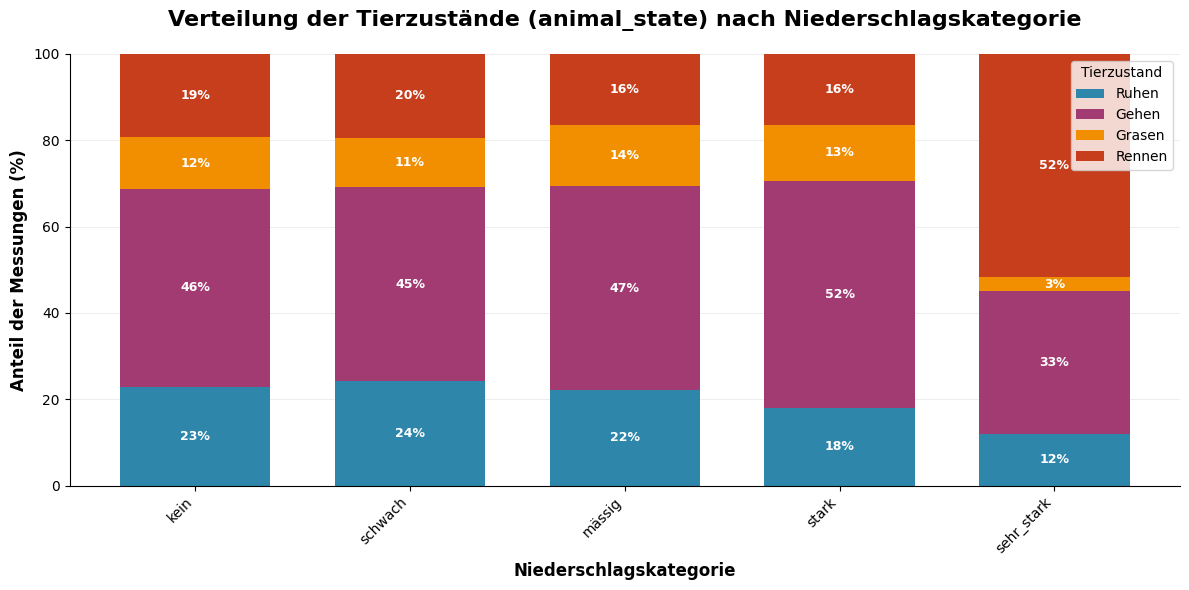


=== Anzahl Messungen pro animal_state und Niederschlagskategorie ===
animal_state   resting  walking  grazing  running
rain_category                                    
kein             38877    78060    20130    32932
schwach           2015     3739      943     1627
mässig             908     1934      586      672
stark              130      378       94      118
sehr_stark          18       50        5       78

=== Prozentuale Verteilung der animal_state pro Niederschlagskategorie (%) ===
animal_state   resting  walking  grazing  running
rain_category                                    
kein              22.9     45.9     11.8     19.4
schwach           24.2     44.9     11.3     19.5
mässig            22.1     47.2     14.3     16.4
stark             18.1     52.5     13.1     16.4
sehr_stark        11.9     33.1      3.3     51.7


In [201]:
# Filtern: nur Zeilen mit gültigem animal_state
df_viz_filtered = df_viz[df_viz['animal_state'].notna()].copy()

# animal_state normalisieren (falls verschiedene Schreibweisen vorkommen)
df_viz_filtered['animal_state'] = df_viz_filtered['animal_state'].str.lower().str.strip()

# Kreuztabelle: Anzahl Messungen pro Regenkategorie und animal_state
activity_by_rain = pd.crosstab(
    df_viz_filtered['rain_category'],
    df_viz_filtered['animal_state']
)

# Regenkategorien sortieren (von kein bis sehr_stark)
rain_order = ['kein', 'sehr_schwach', 'schwach', 'mässig', 'stark', 'sehr_stark']
activity_by_rain = activity_by_rain.reindex([cat for cat in rain_order if cat in activity_by_rain.index])

# Sicherstellen, dass alle 4 Aktivitäten vorhanden sind (falls nicht, mit 0 auffüllen)
for state in ['resting', 'walking', 'grazing', 'running']:
    if state not in activity_by_rain.columns:
        activity_by_rain[state] = 0

# Spalten in gewünschter Reihenfolge sortieren
activity_by_rain = activity_by_rain[['resting', 'walking', 'grazing', 'running']]

# Prozentuale Verteilung je Kategorie berechnen
activity_pct = activity_by_rain.div(activity_by_rain.sum(axis=1), axis=0) * 100

# Stacked Bar Chart (Prozentwerte)
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# Manuelles Zeichnen, um Kontrolle über Labels zu haben
bottom = None
bars = []
state_labels = ['resting', 'walking', 'grazing', 'running']
for i, state in enumerate(state_labels):
    values = activity_pct[state].values
    b = ax.bar(activity_pct.index, values, bottom=bottom, color=colors[i], width=0.7, label=state)
    bars.append(b)
    bottom = values if bottom is None else bottom + values

# Prozentlabels auf jedem Segment anzeigen (nur wenn > 3%)
for i, state in enumerate(state_labels):
    for rect, val in zip(bars[i], activity_pct[state].values):
        if val >= 3:  # kleine Segmente nicht beschriften, um Clutter zu vermeiden
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + rect.get_height() / 2,
                f"{val:.0f}%",
                ha='center', va='center', fontsize=9, color='white', fontweight='bold'
            )

ax.set_title('Verteilung der Tierzustände (animal_state) nach Niederschlagskategorie', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Niederschlagskategorie', fontsize=12, fontweight='bold')
ax.set_ylabel('Anteil der Messungen (%)', fontsize=12, fontweight='bold')
ax.legend(['Ruhen', 'Gehen', 'Grasen', 'Rennen'], title='Tierzustand', loc='upper right', frameon=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Grid anpassen
ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('data/processed/aktivitaetsverteilung.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistik ausgeben (Anzahl Messungen + Prozent)
print('\n=== Anzahl Messungen pro animal_state und Niederschlagskategorie ===')
print(activity_by_rain)
print('\n=== Prozentuale Verteilung der animal_state pro Niederschlagskategorie (%) ===')
print(activity_pct.round(1))

### 3.3 Höhenanalyse der Tiere in Abhängigkeit vom Wetter

Diese Analyse untersucht, ob Niederschlag einen Einfluss auf die Höhenlage hat, in der sich die Tiere aufhalten.
Forschungsfrage: Bewegen sich Tiere bei Regen in tiefere oder höhere Lagen?


In [202]:
# Daten für Höhenanalyse vorbereiten
df_elevation = df_viz[df_viz['elevation'].notna() & df_viz['rain_category'].notna()].copy()

print(f"\n=== Höhenanalyse: Niederschlag ↔ Elevation ===")
print(f"Datensätze mit Elevation und Niederschlag: {len(df_elevation)}")

# Statistik: Durchschnittliche Höhe pro Niederschlagskategorie
elevation_by_rain = df_elevation.groupby('rain_category')['elevation'].agg(['mean', 'std', 'min', 'max', 'count'])

# Regenkategorien sortieren
rain_order = ['kein', 'sehr_schwach', 'schwach', 'mässig', 'stark', 'sehr_stark']
elevation_by_rain = elevation_by_rain.reindex([cat for cat in rain_order if cat in elevation_by_rain.index])

print("\n=== Durchschnittliche Höhe pro Niederschlagskategorie (m ü. M.) ===")
print(elevation_by_rain)



=== Höhenanalyse: Niederschlag ↔ Elevation ===
Datensätze mit Elevation und Niederschlag: 172280

=== Durchschnittliche Höhe pro Niederschlagskategorie (m ü. M.) ===
                      mean        std      min      max   count
rain_category                                                  
kein           2564.111400  67.886346  2421.24  2857.85  159722
schwach        2538.609697  59.870402  2429.95  2827.34    7910
mässig         2554.163908  82.642372  2440.00  2767.13    3777
stark          2535.427028  78.302245  2427.58  2695.41     720
sehr_stark     2651.047748  89.150668  2467.00  2769.97     151


### 3.4 Tageszeitliches Muster des Standorts (Höhe) der Tiere

Diese Analyse untersucht, ob es ein tageszeitliches Muster gibt, in welcher Höhe sich die Tiere aufhalten.
Forschungsfrage: Bewegen sich Tiere zu bestimmten Tageszeiten in höhere oder tiefere Lagen?


In [203]:
# Daten für tageszeitliche Höhenanalyse vorbereiten
df_time_elevation = df_viz[df_viz['elevation'].notna()].copy()
df_time_elevation['spokes_ts'] = pd.to_datetime(df_time_elevation['spokes_ts'])

# Stunde extrahieren (0-23)
df_time_elevation['hour'] = df_time_elevation['spokes_ts'].dt.hour

print(f"\n=== Tageszeitliches Höhenmuster ===")
print(f"Datensätze mit Elevation und Zeitstempel: {len(df_time_elevation)}")

# Statistik: Durchschnittliche Höhe pro Stunde
elevation_by_hour = df_time_elevation.groupby('hour')['elevation'].agg(['mean', 'std', 'min', 'max', 'count'])

print("\n=== Durchschnittliche Höhe pro Tagesstunde (m ü. M.) ===")
print(elevation_by_hour)



=== Tageszeitliches Höhenmuster ===
Datensätze mit Elevation und Zeitstempel: 172280

=== Durchschnittliche Höhe pro Tagesstunde (m ü. M.) ===
             mean        std      min      max  count
hour                                                 
0     2586.796412  72.331804  2492.28  2767.13   6675
1     2593.713437  75.333350  2489.49  2829.93   6616
2     2592.746594  76.802919  2489.49  2804.22   6668
3     2593.979423  77.180121  2470.38  2749.45   6573
4     2589.896676  74.654589  2490.21  2751.40   6523
5     2591.667569  78.379785  2456.72  2783.12   6371
6     2582.453437  84.481570  2447.66  2827.34   6268
7     2560.082305  73.013311  2429.95  2802.78   7509
8     2549.176713  57.319916  2446.79  2715.78   8248
9     2538.088076  43.297537  2446.79  2715.78   8632
10    2535.594146  37.258730  2481.31  2725.03   8294
11    2532.871563  29.355708  2463.65  2636.19   7657
12    2530.836158  30.470771  2421.24  2686.75   7562
13    2533.531677  26.734011  2467.00  2649.19

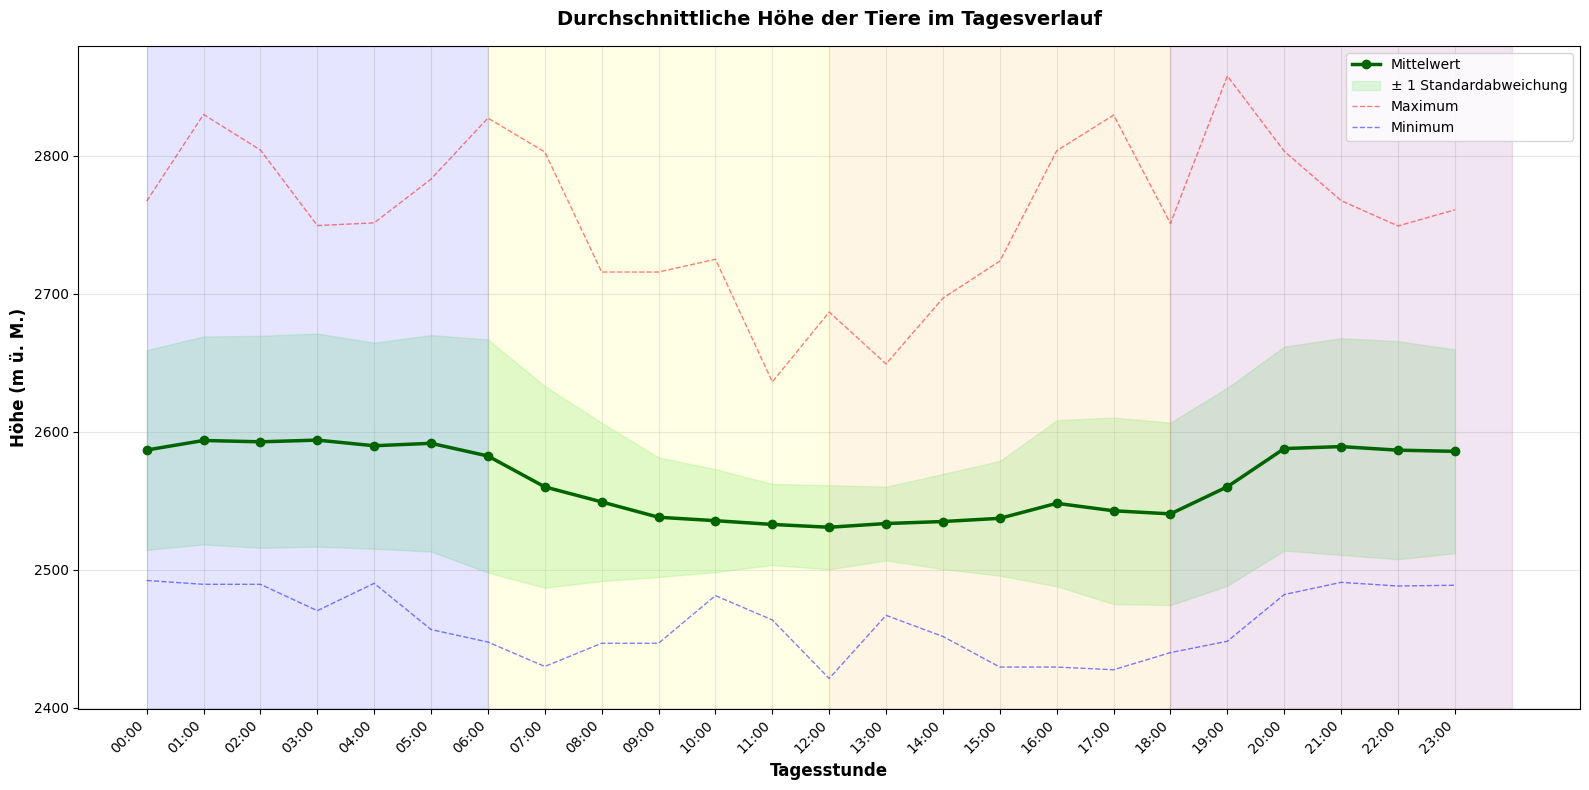

✅ Grafik gespeichert: data/processed/hoehe_tageszeit.png


In [204]:
# Visualisierung 1: Liniendiagramm - Durchschnittliche Höhe über den Tag
fig, ax1 = plt.subplots(figsize=(16, 8))

# Liniendiagramm mit Fehlerbereich (Standardabweichung)
hours = elevation_by_hour.index
means = elevation_by_hour['mean']
stds = elevation_by_hour['std']

ax1.plot(hours, means, color='darkgreen', linewidth=2.5, marker='o', markersize=6, label='Mittelwert')
ax1.fill_between(hours, means - stds, means + stds, alpha=0.3, color='lightgreen', label='± 1 Standardabweichung')

ax1.set_xlabel('Tagesstunde', fontsize=12, fontweight='bold')
ax1.set_ylabel('Höhe (m ü. M.)', fontsize=12, fontweight='bold')
ax1.set_title('Durchschnittliche Höhe der Tiere im Tagesverlauf', fontsize=14, fontweight='bold', pad=15)
ax1.set_xticks(range(0, 24))
ax1.set_xticklabels([f'{h:02d}:00' for h in range(0, 24)], rotation=45, ha='right')
ax1.grid(True, alpha=0.3)

# Tageszeiten markieren (ohne label, da nur visuell)
ax1.axvspan(0, 6, alpha=0.1, color='blue')
ax1.axvspan(6, 12, alpha=0.1, color='yellow')
ax1.axvspan(12, 18, alpha=0.1, color='orange')
ax1.axvspan(18, 24, alpha=0.1, color='purple')

# Min/Max-Bereich als Linie
ax1.plot(hours, elevation_by_hour['max'], color='red', linewidth=1, linestyle='--', alpha=0.5, label='Maximum')
ax1.plot(hours, elevation_by_hour['min'], color='blue', linewidth=1, linestyle='--', alpha=0.5, label='Minimum')

# Legende nach allen Plots
ax1.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('data/processed/hoehe_tageszeit.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafik gespeichert: data/processed/hoehe_tageszeit.png")


### Interpretation der Ergebnisse

**Aktivitätsverteilung nach Niederschlag:**
Zu ergänzen

**Tageszeitliches Muster des Standorts (Höhe) der Tiere**
Zu ergänzen


In [205]:
time_anlysies = time.time() - start_analyzis
print(f"Datenanalyse-Verarbeitung: {time_anlysies:.2f} Sekunden")

Datenanalyse-Verarbeitung: 16.95 Sekunden


## 4. Performance-Messungen

In [206]:
print("\n+------------------------------+-----------+")
print("| Schritt                      | Zeit (s)  |")
print("+------------------------------+-----------+")
print(f"| Daten-Verarbeitung           | {time_dataload:9.2f} |")
print(f"| Join-Verarbeitung            | {time_joins:9.2f} |")
print(f"| Datenanalyse-Verarbeitung    | {time_anlysies:9.2f} |")
print("+------------------------------+-----------+")
print(f"| Job-Verarbeitung (Total)     | {time.time() - start_job:9.2f} |")
print("+------------------------------+-----------+\n")



+------------------------------+-----------+
| Schritt                      | Zeit (s)  |
+------------------------------+-----------+
| Daten-Verarbeitung           |      1.14 |
| Join-Verarbeitung            |      5.19 |
| Datenanalyse-Verarbeitung    |     16.95 |
+------------------------------+-----------+
| Job-Verarbeitung (Total)     |     29.16 |
+------------------------------+-----------+



In [207]:
#Nur auf ZHAW-Cluster nötig
if(zhaw_cluster == 1):
    print("Beende Spark-Session auf ZHAW-Cluster...")
    sc.stop()